# Competitive Auctions on eBay.com

In [1]:
from pathlib import Path
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt

import dmba

from dmba import classificationSummary, AIC_score
from dmba import gainsChart, liftChart

%matplotlib inline

Data preprocessing: 
Split the data into training (60%) and validation (40%) datasets. Use the random seed 1.

In [2]:
ebay_df = dmba.load_data('eBayAuctions.csv')

# convert categorical variables into indicator and drop the first column of each of them
ebay_df = pd.get_dummies(ebay_df, prefix_sep='_', drop_first=True)

y = ebay_df['Competitive?']
X = ebay_df.drop(columns=['Competitive?'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

ebay_df.head()

,sellerRating,Duration,ClosePrice,OpenPrice,Competitive?,Category_Automotive,Category_Books,Category_Business/Industrial,Category_Clothing/Accessories,Category_Coins/Stamps,...,Category_SportingGoods,Category_Toys/Hobbies,currency_GBP,currency_US,endDay_Mon,endDay_Sat,endDay_Sun,endDay_Thu,endDay_Tue,endDay_Wed
0,3249,5,0.01,0.01,0,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
1,3249,5,0.01,0.01,0,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
2,3249,5,0.01,0.01,0,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
3,3249,5,0.01,0.01,0,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
4,3249,5,0.01,0.01,0,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False


In [3]:
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns))
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -0.4349743940019724
                                  coeff
sellerRating                  -0.000045
Duration                       0.011929
ClosePrice                     0.089180
OpenPrice                     -0.106160
Category_Automotive           -0.552589
Category_Books                 0.261154
Category_Business/Industrial   1.390326
Category_Clothing/Accessories -1.226198
Category_Coins/Stamps         -2.051265
Category_Collectibles         -0.010454
Category_Computer             -0.117490
Category_Electronics           0.584440
Category_EverythingElse       -1.808263
Category_Health/Beauty        -1.969016
Category_Home/Garden          -0.071131
Category_Jewelry              -0.497255
Category_Music/Movie/Game      0.138927
Category_Photography           1.681984
Category_Pottery/Glass        -0.181690
Category_SportingGoods        -0.073011
Category_Toys/Hobbies          0.313955
currency_GBP                   1.770557
currency_US                    0.552216
endDay_Mo

In [4]:
# confusion matrix
print('Training')
classificationSummary(train_y, logit_reg.predict(train_X))

print('Validation')
classificationSummary(valid_y, logit_reg.predict(valid_X))

Training
Confusion Matrix (Accuracy 0.7878)

       Prediction
Actual   0   1
     0 443 110
     1 141 489
Validation
Confusion Matrix (Accuracy 0.7567)

       Prediction
Actual   0   1
     0 274  79
     1 113 323


In [5]:
train_X = train_X.drop(columns=['ClosePrice'])
valid_X = valid_X.drop(columns=['ClosePrice'])

In [6]:
logit_reg2 = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg2.fit(train_X, train_y)

# confusion matrix
print('Training')
classificationSummary(train_y, logit_reg2.predict(train_X))

print('Validation')
classificationSummary(valid_y, logit_reg2.predict(valid_X))

Training
Confusion Matrix (Accuracy 0.6881)

       Prediction
Actual   0   1
     0 349 204
     1 165 465
Validation
Confusion Matrix (Accuracy 0.6401)

       Prediction
Actual   0   1
     0 204 149
     1 135 301


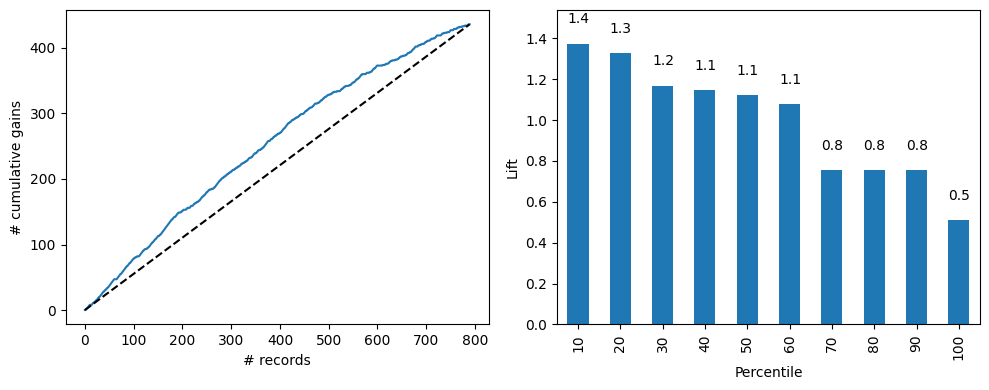

In [7]:
logit_reg_pred = logit_reg2.predict(valid_X)
logit_reg_proba = logit_reg2.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()